In [1]:
import sys
sys.path.append('..//')

import jax
import pickle
from jax import jit
import jax.numpy as jnp

jax.config.update("jax_enable_x64", False)
jax.config.update('jax_platform_name', 'cpu')

from parsmooth._base import MVNStandard, FunctionalModel
from parsmooth.linearization import extended, second_order
from bearing_data import get_data, make_parameters
from parsmooth.sequential._ls_newton import _iterated_recursive_newton_smoother
from parsmooth.sequential._ls_newton import _iterated_batch_newton_smoother


In [2]:
s1 = jnp.array([-1.5, 0.5])  # First sensor location
s2 = jnp.array([1., 1.])  # Second sensor location
r = 0.5  # Observation noise (stddev)
x0 = jnp.array([0.1, 0.2, 1, 0])  # initial true location
dt = 0.01  # discretization time step
qc = 0.01  # discretization noise
qw = 0.1  # discretization noise

Q, R, observation_function, transition_function, _, _ = make_parameters(qc, qw, r, dt, s1, s2)

m0 = jnp.array([-4., -1., 2., 7., 3.])
P0 = jnp.eye(5)

init = MVNStandard(m0, P0)

transition_model = FunctionalModel(transition_function, MVNStandard(jnp.zeros((5,)), Q))
observation_model = FunctionalModel(observation_function, MVNStandard(jnp.zeros((2,)), R))

In [3]:
n_run = 20
Ts = [100, 200, 300, 400, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000]


In [4]:
# Data_measurements = []
# for t, T in enumerate(Ts):
#     data = []
#     for i in range(n_run):
#         _, true_states, ys = get_data(x0, dt, r, T, s1, s2)
#         data.append({'ys': ys})
#     Data_measurements.append(data)
#
# with  open("eusipco_outputs/data_measurements.pkl", "wb") as open_file:
#     pickle.dump(Data_measurements, open_file)

In [5]:
with open("eusipco_outputs/data_measurements.pkl", "rb") as open_file:
    Data_measurements = pickle.load(open_file)

In [6]:
import numpy as np
import time
def func(method, lengths, data, n_runs=n_run, n_iter=30, mth='newton_recursive'):
    res_mean = []
    res_median = []
    for t, T in enumerate(lengths):
        print(f"Length {t+1} out of {len(lengths)}")
        run_times = []
        initial_states =  MVNStandard(jnp.repeat(jnp.array([[-1., -1., 6., 4., 2.]]),T + 1, axis=0),
                                                                 jnp.repeat(jnp.eye(5).reshape(1, 5, 5), T + 1, axis=0))
        for i in range(n_runs):
            ys = data[t][i]['ys']
            args = ys, initial_states, n_iter


            tic = time.time()
            method_res = method(*args)
            toc = time.time()
            run_times.append(toc - tic)
            print(f"run {i+1} out of {n_runs}", end="\r")
        res_mean.append(np.mean(run_times))
        res_median.append(np.median(run_times))
        np.savez("eusipco_outputs/TIME-CPU-"+mth+"-"+str(t), time = np.array(run_times))
    print()

    return np.array(res_mean), np.array(res_median)


In [7]:
# Newton Recursive Iterated Smoother
def iterated_recursive_newton_smoother(observations, nominal_trajectory, iteration):
    newton_smoothed_recursive = _iterated_recursive_newton_smoother(observations, init,transition_model,
                                                           observation_model,second_order, extended,nominal_trajectory
                                                           ,n_iter=30)[0]
    return newton_smoothed_recursive

# Gauss-Newton Batch Iterated Smoother?
def  iterated_batch_newton_smoother(observations, nominal_trajectory, iteration):
    newton_smoothed_batch = _iterated_batch_newton_smoother(observations, init,
                                                      transition_model, observation_model,
                                                      second_order, nominal_trajectory.mean,
                                                      n_iter=30)[0]
    return newton_smoothed_batch

In [8]:
cpu_recursive = jit(iterated_recursive_newton_smoother, backend="cpu")
cpu_batch = jit(iterated_batch_newton_smoother, backend="cpu")

In [9]:
cpu_recursive_runtime = func(cpu_recursive, Ts, Data_measurements, mth='newton_recursive')
jnp.savez("eusipco_outputs/recursive_runtime15",
          cpu_recursive_runtime = cpu_recursive_runtime)


Length 1 out of 20
Length 2 out of 20
Length 3 out of 20
Length 4 out of 20
Length 5 out of 20
Length 6 out of 20
Length 7 out of 20
Length 8 out of 20
Length 9 out of 20
Length 10 out of 20
Length 11 out of 20
Length 12 out of 20
Length 13 out of 20
Length 14 out of 20
Length 15 out of 20
Length 16 out of 20
Length 17 out of 20
Length 18 out of 20
Length 19 out of 20
Length 20 out of 20
run 20 out of 20


In [10]:
cpu_batch_runtime = func(cpu_batch, Ts, Data_measurements, mth='newton_batch')
jnp.savez("eusipco_outputs/batch_runtime15",
          cpu_batch_runtime = cpu_batch_runtime)

Length 1 out of 20
Length 2 out of 20
Length 3 out of 20
Length 4 out of 20
Length 5 out of 20
Length 6 out of 20
Length 7 out of 20
Length 8 out of 20
Length 9 out of 20


KeyboardInterrupt: 

In [13]:
Ts_slice = [100, 200, 300, 400, 500, 1000, 1500, 2000]#, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000]
mth='newton_batch'
batch_time_slices = []
for t in range(len(Ts_slice)):
    with np.load("eusipco_outputs/TIME-CPU-"+mth+"-"+str(t)+".npz") as loaded:
        batch_time_slices.append(loaded["time"])

# np.savez("new_outputs/ell_float32_extended_sqrt_runtime15",
#           rts_gpu_IEKS_sqrt_par_ell = rts_gpu_IEKS_sqrt_par_ell)

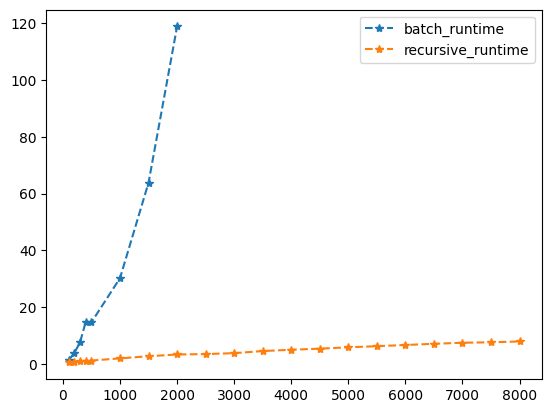

In [28]:
from matplotlib import pyplot as plt

plt.plot(Ts_slice, np.mean(batch_time_slices, axis=1),'--*', label="batch_runtime")
plt.plot(Ts, cpu_recursive_runtime[0],'--*', label="recursive_runtime")
plt.legend();

In [21]:
np.mean(batch_time_slices, axis=1)

array([  1.26248115,   3.85298748,   7.58908318,  14.81650671,
        14.6597852 ,  30.19471211,  63.83150755, 118.83212839])

In [27]:
jnp.mean(jnp.array(batch_time_slices)[0])

Array(1.2624811, dtype=float32)

In [ ]:
import pandas as pd

data_runtime_batch_seq = np.stack([Ts,
                                   cpu_batch_runtime[0],
                                   cpu_recursive_runtime[0]],
                                  axis=1)

columns = ["times",
          "cpu_batch_runtime",
          "cpu_recursive_runtime"]

df1 = pd.DataFrame(data=data_runtime_batch_seq, columns=columns)
df1.to_csv("eusipco_outputs/batch_seq_runtime.csv")